In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import pickle as pkl

import cmlreaders as cml
import cluster_helper.cluster
import matplotlib.pyplot as plt
from numpy.lib.recfunctions import append_fields

import warnings
warnings.filterwarnings("ignore")

from constants import enc_sig_subjects, ret_sig_subjects
from utils import get_behavioral_score

In [9]:
labeled_events = pkl.load(open('FR2_all_events_clustered.pkl','rb'))
enc_labeled_events = labeled_events[labeled_events['type']=='WORD']
ret_labeled_events = labeled_events[labeled_events['type']=='REC_WORD']

encresults = [pkl.load(open('scratch/mtpower/%s/%s_enc_enc_clsf_result.pkl'%(subject,subject),'rb')) 
              for subject in enc_sig_subjects]

retciresults = [pkl.load(open('scratch/mtpower/%s/%s_retci_retci_clsf_result.pkl'%(subject,subject),'rb')) 
                for subject in ret_sig_subjects]

#### identify event cluster type

In [96]:
all_events = pkl.load(open('FR2_all_events.pkl','rb'))

In [101]:
# label encoding events into four conditions:
# 1. TC, subsequently recalled and temporally clustered (lag_before==1 or lag_after==-1, sim <= 0.4)
# 2. SC, subsequently recalled and semantically clustered (sim >= 0.4, not TC)
# 3. NC, subsequently recalled and not clustered (not SC and not TC but recalled)
# 4. NR, subsequently not recalled
# 5. BC, both temporally and semantically clustered

import scipy.io as sio
was_sims = np.loadtxt('/home1/liyuxuan/notebooks/pools/wasnorm_was.txt')

def label_cluster_status(subject):
    
    def enc_subsequent_clustering_type(lag1, lag2, sim1, sim2):

        TC = False
        SC = False

        # semantic clustering?
        if sim1 >= 0.4 or sim2 >= 0.4:
            SC = True

        # temporal clustering?
        # - relative to encoding state effectiveness 
        # - increase transition probability of ith word and i-1th word
        if lag1==1 or lag2==-1:
            TC = True

        if TC is True and SC is True: return 'BC'
        if TC is True and SC is False: return 'TC'
        if TC is False and SC is True: return 'SC'
        else: return 'NC'
        
    def ret_clustering_type(lag1, lag2, sim1, sim2):
        
        TC = False
        SC = False

        if np.abs(lag2)==1:
            TC = True
        
        if sim2 >=0.4:
            SC = True
        
        if TC is True and SC is True: return 'BC'
        if TC is True and SC is False: return 'TC'
        if TC is False and SC is True: return 'SC'
        else: return 'NC'
    
    print (subject, end=',')
    
    events = all_events[all_events['subject']==subject]
    conditions = np.array(['  '] * len(events))
    all_lag1 = np.ones(len(events)) * np.nan
    all_lag2 = np.ones(len(events)) * np.nan
    all_sim1 = np.ones(len(events)) * np.nan
    all_sim2 = np.ones(len(events)) * np.nan
    all_time1 = np.ones(len(events)) * np.nan
    all_time2 = np.ones(len(events)) * np.nan
    
    for s in np.unique(events['session']):
        sess_data = events[events['session']==s]
        
        for t in np.unique(sess_data['trial']):
            
            # crop out and initialize some variables
            trial_index = np.bitwise_and(events['session']==s, events['trial']==t)
            trial_data = events[trial_index]
            
            enc_events = trial_data[trial_data['type']=='WORD']
            if len(enc_events) != 24: continue # what is wrong with such list???
            ret_events = trial_data[trial_data['type']=='REC_WORD']
            
            enc_conditions = [None] * len(enc_events)
            ret_conditions = [None] * len(ret_events)
            trial_lag1 = np.ones(len(ret_events)) * np.nan
            trial_lag2 = np.ones(len(ret_events)) * np.nan
            trial_sim1 = np.ones(len(ret_events)) * np.nan
            trial_sim2 = np.ones(len(ret_events)) * np.nan
            trial_time1 = np.ones(len(ret_events)) * np.nan
            trial_time2 = np.ones(len(ret_events)) * np.nan
            
            serialpos = ret_events['serialpos'].values
            itemno = [int(no) for no in ret_events['item_num'].values] # wordID (itemno) ranges from 1-1638
            rectimes = ret_events['rectime'].values
            
            intrusions = ret_events['intrusion'].values!=0
            repetitions = pd.Series(itemno).duplicated().values # can't use serialpos for repetitions
            
            # go through each retrieval, determine its clustering status
            for i in range(len(ret_events)):
                
                if (intrusions[i]):
                    if ret_events['intrusion'].values[i]==-1:
                        trial_lag1[i] = np.nan
                        trial_lag2[i] = np.nan
                    else:
                        trial_lag1[i] = ret_events['intrusion'].values[i] # n list back
                        trial_lag2[i] = np.nan
                    if i-1 in range(0, len(serialpos)) and (itemno[i-1] != -1): # can't get similarity if it is an ELI
                        trial_sim1[i] = was_sims[itemno[i]-1, itemno[i-1]-1]
                    if i+1 in range(0, len(serialpos)) and (itemno[i+1] != -1):
                        trial_sim2[i] = was_sims[itemno[i]-1, itemno[i+1]-1]
                    continue
                
                lag1, lag2 = np.nan, np.nan
                sim1, sim2 = np.nan, np.nan
                time1, time2 = np.nan, np.nan
                
                if i-1 in range(0, len(serialpos)) and not intrusions[i-1]:
                    lag1 = serialpos[i] - serialpos[i-1]
                    trial_lag1[i] = lag1
                    time1 = rectimes[i] - rectimes[i-1]
                    trial_time1[i] = time1
                if i+1 in range(0, len(serialpos)) and not intrusions[i+1]:
                    lag2 = serialpos[i+1] - serialpos[i]
                    trial_lag2[i] = lag2
                    time2 = rectimes[i+1] - rectimes[i]
                    trial_time2[i] = time2
                
                if i-1 in range(0, len(serialpos)):
                    if itemno[i-1] != -1: # can't get similarity if it is an ELI
                        sim1 = was_sims[itemno[i]-1, itemno[i-1]-1]
                        trial_sim1[i] = sim1
                if i+1 in range(0, len(serialpos)):
                    if itemno[i+1] != -1:
                        sim2 = was_sims[itemno[i]-1, itemno[i+1]-1]
                        trial_sim2[i] = sim2
                
                if not repetitions[i]:
                    enc_conditions[serialpos[i]-1] = enc_subsequent_clustering_type(lag1, lag2, sim1, sim2)
                    ret_conditions[i] = ret_clustering_type(lag1, lag2, sim1, sim2)
                    
                # print i, serialpos[i], ret_events['item_name'][i]
                # print lag1, lag2, '%.2f'%sim1, '%.2f'%sim2, c
                # print
            
            # fill the big array with trial arrays
            enc_conditions = [c if c != None else 'NR' for c in enc_conditions]
            ret_conditions = [c if c != None else 'IN' for c in ret_conditions]
            conditions[trial_index] = np.concatenate((enc_conditions, ret_conditions))
            all_lag1[trial_index] = np.concatenate((np.ones(24)*np.nan, trial_lag1)) # nan for encoding events
            all_lag2[trial_index] = np.concatenate((np.ones(24)*np.nan, trial_lag2))
            all_sim1[trial_index] = np.concatenate((np.ones(24)*np.nan, trial_sim1))
            all_sim2[trial_index] = np.concatenate((np.ones(24)*np.nan, trial_sim2))
            all_time1[trial_index] = np.concatenate((np.ones(24)*np.nan, trial_time1))
            all_time2[trial_index] = np.concatenate((np.ones(24)*np.nan, trial_time2))
            
    labeled_events = events.assign(cluster_type=conditions,
                                   lag1=all_lag1,
                                   lag2=all_lag2,
                                   sim1=all_sim1,
                                   sim2=all_sim2,
                                   timebefore=all_time1,
                                   timeafter=all_time2)
    
    return labeled_events

In [102]:
results = [label_cluster_status(s) for s in FR2_valid_subjects]
labeled_events = pd.concat(results)
# pkl.dump(labeled_events, open('FR2_all_events_clustered.pkl','wb'))

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

In [24]:
labeled_events = pkl.load(open('FR2_all_events_clustered.pkl','rb'))
enc_labeled_events = labeled_events[labeled_events['type']=='WORD']
ret_labeled_events = labeled_events[labeled_events['type']=='REC_WORD']

#### encoding list dynamics

In [4]:
# encoding output by clustering type and serial position - data 
BCall = []
TCall = []
SCall = []
NCall = []
NRall = []
for i, subject in enumerate(enc_sig_subjects):
    print(subject, end=',')
    
    def get_cluster_type(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data['cluster_type'][events_index]
    
    def mean_yhat(all_yhat, events):
        result = []
        for sess in np.unique(events['session']):
            # if clean data: some sessions are missing items
            if subject == 'LTP246' and sess == 6: # LTP246 sess 6 trial 4 has only one item
                sess_index = (events['session']==sess) & (events['trial']!=4)
            elif subject == 'LTP258' and sess == 17: # LTP258 sess 17 trial 1 has only 14 items
                sess_index = (events['session']==sess) & (events['trial']!=1)
            else:
                sess_index = events['session']==sess
            n_list = len(np.unique(events[sess_index]['trial']))
            yhat = all_yhat[sess_index].reshape(n_list, 24)
            result.append(np.nanmean(yhat, 0))
        return np.nanmean(result, 0)
    
    def extract_one_type(yhat, events, conditions, ctype):
        x = yhat.copy()
        x[conditions!=ctype] = np.nan
        x = mean_yhat(x, events)
        return x
    
    yhat = encresults[i]['yhat']
    events = encresults[i]['events']
    conditions = get_cluster_type(events, enc_labeled_events)
    BCall.append(extract_one_type(yhat, events, conditions, 'BC'))
    TCall.append(extract_one_type(yhat, events, conditions, 'TC'))
    SCall.append(extract_one_type(yhat, events, conditions, 'SC'))
    NCall.append(extract_one_type(yhat, events, conditions, 'NC'))
    NRall.append(extract_one_type(yhat, events, conditions, 'NR'))

BCall = np.array(BCall)
TCall = np.array(TCall)
SCall = np.array(SCall)
NCall = np.array(NCall)
NRall = np.array(NRall)

LTP093,LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP228,LTP229,LTP236,LTP246,LTP249,LTP250,LTP251,LTP258,LTP259,LTP265,LTP269,LTP273,LTP278,LTP279,LTP280,LTP283,LTP285,LTP287,LTP293,LTP296,LTP297,LTP299,LTP301,LTP302,LTP303,LTP304,LTP305,LTP306,LTP307,LTP310,LTP311,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP324,LTP325,LTP326,LTP327,LTP328,LTP329,LTP331,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP344,LTP346,LTP347,LTP348,LTP349,LTP354,LTP355,LTP357,LTP360,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP374,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP391,LTP393,

In [5]:
x = {'BCall':BCall, 'TCall':TCall, 'SCall':SCall, 'NCall':NCall, 'NRall':NRall}
# pkl.dump(x, open('data/clsf_enc_output_ctypes.pkl','wb'))

In [171]:
x = pkl.load(open('data/clsf_enc_output_ctypes.pkl','rb'))
BCall = x['BCall']
TCall = x['TCall']
SCall = x['SCall']
NCall = x['NCall']
NRall = x['NRall']

Text(11.75, 0.5, 'Classifier Output')

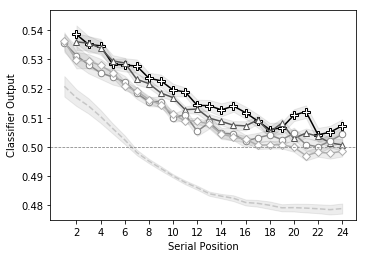

In [4]:
from plot_utils import plot_list_dynamics

values = [BCall, TCall, SCall, NCall, NRall]
labels=['BC','TC','SC','NC','NR']
colors=['k','#555555','#888888','#adadad','#c6c6c6']
markers=['P','^','o','D','']
markersizes=[7.5,6.5,6.5,5.5,0]
linestyles=['-','-','-','-','--']
xticks=np.arange(24)
jitters=[0]*len(values)

value_dict = {}
for i, label in enumerate(labels):
    value_dict[label] = {'value':values[i], 'color':colors[i], 'linestyle':linestyles[i],
                         'marker':markers[i], 'markersize':markersizes[i],
                         'xticks':xticks, 'jitter':jitters[i]}

fig, ax = plot_list_dynamics(value_dict)

ax.set_ylim([0.50,0.54])
ax.set_ylabel('Encoding Classifier Output')

ax.axhline(y=0.5, ls='--', lw=0.75, color='gray')

ax.set_xticks(range(24)[1::2])
ax.set_xticklabels(np.arange(1,25,1)[1::2])
ax.set_ylim([0.475,0.547])
ax.set_xlabel('Serial Position')
ax.set_ylabel('Classifier Output')

In [5]:
# fig.savefig('figures_final/yhat_enc.pdf', bbox_inches="tight")

In [172]:
# mixed model data
data = pd.DataFrame(pd.Series(enc_sig_subjects,name='subject'))

data['BC_early'] = np.nanmean(BCall[:, :4], axis=1)
data['BC_mid'] = np.nanmean(BCall[:, 4:-4], axis=1)
data['BC_late'] = np.nanmean(BCall[:, -4:], axis=1)

data['TC_early'] = np.nanmean(TCall[:, :4], axis=1)
data['TC_mid'] = np.nanmean(TCall[:, 4:-4], axis=1)
data['TC_late'] = np.nanmean(TCall[:, -4:], axis=1)

data['SC_early'] = np.nanmean(SCall[:, :4], axis=1)
data['SC_mid'] = np.nanmean(SCall[:, 4:-4], axis=1)
data['SC_late'] = np.nanmean(SCall[:, -4:], axis=1)

data['NC_early'] = np.nanmean(NCall[:, :4], axis=1)
data['NC_mid'] = np.nanmean(NCall[:, 4:-4], axis=1)
data['NC_late'] = np.nanmean(NCall[:, -4:], axis=1)

data['NR_early'] = np.nanmean(NRall[:, :4], axis=1)
data['NR_mid'] = np.nanmean(NRall[:, 4:-4], axis=1)
data['NR_late'] = np.nanmean(NRall[:, -4:], axis=1)

In [162]:
data.head()

,subject,BC_early,BC_mid,BC_late,TC_early,TC_mid,TC_late,SC_early,SC_mid,SC_late,NC_early,NC_mid,NC_late,NR_early,NR_mid,NR_late
0,LTP093,0.493747,0.512258,0.516125,0.492975,0.514413,0.513928,0.474596,0.514043,0.523360,0.495199,0.506786,0.506264,0.481119,0.498234,0.500963
1,LTP106,0.538734,0.506887,0.487378,0.536505,0.498714,0.488360,0.537306,0.498045,0.503110,0.535322,0.500512,0.489046,0.522655,0.483301,0.467376
2,LTP115,0.539043,0.507358,0.502395,0.532974,0.498723,0.490687,0.533570,0.498906,0.490096,0.528881,0.496179,0.492517,0.517805,0.491766,0.481659
3,LTP117,0.516558,0.512910,0.493219,0.507671,0.508256,0.491545,0.499404,0.504422,0.503940,0.497324,0.504401,0.493728,0.493084,0.495710,0.488831
4,LTP123,0.507095,0.512623,0.504997,0.509499,0.507963,0.502228,0.504908,0.501435,0.498311,0.510574,0.501890,0.497535,0.500539,0.495271,0.492306


In [174]:
df = []
for subject in np.unique(data['subject']):
    yhat = data[data['subject']==subject].values[:,1:].T # first item is subject name
    x = pd.DataFrame(data=yhat, columns=['yhat'])
    x['subject'] = [subject] * len(yhat)
    x['event_type'] = np.repeat(['BC','TC','SC','NC','NR'], 3)
    x['listpos'] = np.tile(['early','mid','late'], 5)
    df.append(x)
df = pd.concat(df)

In [175]:
# df.to_csv('data/enc_yhat.csv')

#### retrieval list dynamics

In [25]:
# retrieval output by clustering type and recall time - data 

CRall = []
BCall = []
TCall = []
SCall = []
NCall = []
INall = []
PIall = []
EIall = []

for i, subject in enumerate(ret_sig_subjects):
    print(subject, end=',')
    
    def get_cluster_type(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data['cluster_type'][events_index]
    
    def find_bins(t, bins=np.arange(0, 75.1, 7.5)):
        return np.where(t>bins)[0][-1]
    
    def bin_trial(trial_yhat, bins):
        result = []
        for b in range(10):
            if b not in bins: # no recall in that bin
                result.append(np.nan)
            else:
                result.append(np.nanmean(trial_yhat[bins==b]))
        return np.array(result)
    
    def bin_session(sess_yhat, trial, bins):
        result = []
        for t in np.unique(trial):
            index = trial==t
            trial_result = bin_trial(sess_yhat[index], bins[index])
            result.append(trial_result)
        result = np.array(result)
        return np.nanmean(result,0)
    
    def extract_one_type(yhat, events, conditions, ctype, bins):
        x = yhat.copy()
        if ctype=='CR':
            x[events['intrusion']!=0] = np.nan
        elif ctype=='IN':
            x[events['intrusion']==0] = np.nan
        elif ctype=='PI':
            x[events['intrusion']<=0] = np.nan
        elif ctype=='EI':
            x[events['intrusion']>=0] = np.nan
        else:
            x[conditions!=ctype] = np.nan
        session = events['session']
        trial = events['trial']
        binned_x = []
        for sess in np.unique(session):
            index = session==sess
            sess_x = bin_session(x[index], trial[index], bins[index])
            binned_x.append(sess_x)
        return np.nanmean(binned_x,0)
    
    yhat = retciresults[i]['yhat']
    events = retciresults[i]['events']
    conditions = get_cluster_type(events, ret_labeled_events)

    session = events['session']
    trial = events['trial']
    bins = np.array([find_bins(t/1000.0) for t in events['rectime']])
        
    CRall.append(extract_one_type(yhat, events, conditions, 'CR', bins))
    BCall.append(extract_one_type(yhat, events, conditions, 'BC', bins))
    TCall.append(extract_one_type(yhat, events, conditions, 'TC', bins))
    SCall.append(extract_one_type(yhat, events, conditions, 'SC', bins))
    NCall.append(extract_one_type(yhat, events, conditions, 'NC', bins))
    INall.append(extract_one_type(yhat, events, conditions, 'IN', bins))
    PIall.append(extract_one_type(yhat, events, conditions, 'PI', bins))
    EIall.append(extract_one_type(yhat, events, conditions, 'EI', bins))
    
CRall = np.array(CRall)
INall = np.array(INall)
PIall = np.array(PIall)
EIall = np.array(EIall)
BCall = np.array(BCall)
TCall = np.array(TCall)
SCall = np.array(SCall)
NCall = np.array(NCall)

LTP106,LTP115,LTP117,LTP123,LTP133,LTP138,LTP207,LTP210,LTP229,LTP251,LTP258,LTP259,LTP273,LTP278,LTP279,LTP280,LTP285,LTP287,LTP296,LTP297,LTP301,LTP304,LTP306,LTP307,LTP310,LTP312,LTP316,LTP317,LTP318,LTP321,LTP322,LTP323,LTP325,LTP326,LTP329,LTP334,LTP336,LTP339,LTP341,LTP342,LTP343,LTP346,LTP347,LTP348,LTP349,LTP354,LTP357,LTP361,LTP362,LTP364,LTP365,LTP366,LTP367,LTP371,LTP372,LTP373,LTP376,LTP377,LTP385,LTP386,LTP387,LTP389,LTP390,LTP393,

In [26]:
# saving them cuz they take so long to run...
x = {'CRall':CRall, 'INall':INall, 'PIall':PIall, 'EIall':EIall,
     'BCall':BCall, 'TCall':TCall, 'SCall':SCall, 'NCall':NCall}
# pkl.dump(x, open('data/clsf_retci_output_ctypes.pkl','wb'))

In [166]:
x = pkl.load(open('data/clsf_retci_output_ctypes.pkl','rb'))
CRall = x['CRall']
BCall = x['BCall']
TCall = x['TCall']
SCall = x['SCall']
NCall = x['NCall']
INall = x['INall']
PIall = x['PIall']
EIall = x['EIall']

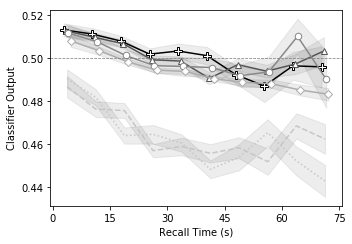

In [14]:
from plot_utils import plot_list_dynamics

values = [BCall, TCall, SCall, NCall, PIall, EIall]
labels=['BC','TC','SC','NC','PLI','ELI']
colors=['k','#555555','#888888','#adadad','#c6c6c6','#c6c6c6']
markers=['P','^','o','D','','']
markersizes=[7.5,6.5,6.5,5.5,0,0]
linestyles=['-','-','-','-','--',':']
xticks = np.arange(7.5, 75.1, 7.5)-7.5/2
jitters = [-0.9,-0.3,0.3,0.9,0,0]

value_dict = {}
for i, label in enumerate(labels):
    value_dict[label] = {'value':values[i], 'color':colors[i], 'linestyle':linestyles[i],
                         'marker':markers[i], 'markersize':markersizes[i],
                         'xticks':xticks, 'jitter':jitters[i]}

fig, ax = plot_list_dynamics(value_dict)

ax.axhline(0.5, ls='--', lw=0.75, color='gray')
# ax.set_ylim([0.43,0.524])
ax.set_xticks(np.arange(0,76,15))
ax.set_xticklabels(np.arange(0,76,15))
ax.set_xlabel('Recall Time (s)')
ax.set_ylabel('Classifier Output')

# ax.legend(loc=3, fontsize='medium')
fig.tight_layout()

In [15]:
# fig.savefig('figures_final/yhat_retci.pdf', bbox_inches="tight")

In [167]:
# mixed model data
retdata = pd.DataFrame(pd.Series(ret_sig_subjects, name='subject'))

retdata['BC_early'] = np.nanmean(BCall[:, :3], axis=1)
retdata['BC_mid'] = np.nanmean(BCall[:, 3:-3], axis=1)
retdata['BC_late'] = np.nanmean(BCall[:, -3:], axis=1)

retdata['TC_early'] = np.nanmean(TCall[:, :3], axis=1)
retdata['TC_mid'] = np.nanmean(TCall[:, 3:-3], axis=1)
retdata['TC_late'] = np.nanmean(TCall[:, -3:], axis=1)

retdata['SC_early'] = np.nanmean(SCall[:, :3], axis=1)
retdata['SC_mid'] = np.nanmean(SCall[:, 3:-3], axis=1)
retdata['SC_late'] = np.nanmean(SCall[:, -3:], axis=1)

retdata['NC_early'] = np.nanmean(NCall[:, :3], axis=1)
retdata['NC_mid'] = np.nanmean(NCall[:, 3:-3], axis=1)
retdata['NC_late'] = np.nanmean(NCall[:, -3:], axis=1)

retdata['IN_early'] = np.nanmean(INall[:, :3], axis=1)
retdata['IN_mid'] = np.nanmean(INall[:, 3:-3], axis=1)
retdata['IN_late'] = np.nanmean(INall[:, -3:], axis=1)

retdata['PI_early'] = np.nanmean(PIall[:, :3], axis=1)
retdata['PI_mid'] = np.nanmean(PIall[:, 3:-3], axis=1)
retdata['PI_late'] = np.nanmean(PIall[:, -3:], axis=1)

retdata['EI_early'] = np.nanmean(EIall[:, :3], axis=1)
retdata['EI_mid'] = np.nanmean(EIall[:, 3:-3], axis=1)
retdata['EI_late'] = np.nanmean(EIall[:, -3:], axis=1)

In [18]:
retdata.head()

,subject,BC_early,BC_mid,BC_late,TC_early,TC_mid,TC_late,SC_early,SC_mid,SC_late,...,NC_late,IN_early,IN_mid,IN_late,PI_early,PI_mid,PI_late,EI_early,EI_mid,EI_late
0,LTP106,0.523108,0.486924,0.472109,0.518459,0.486299,0.518983,0.514394,0.468545,0.444827,...,0.459838,0.480316,0.454308,0.478268,0.470434,0.440307,0.473832,0.493989,0.474639,0.463474
1,LTP115,0.515223,0.485694,0.467790,0.513769,0.487061,0.475899,0.506587,0.484418,0.462225,...,0.473840,0.489605,0.447046,0.447413,0.487532,0.437726,0.401503,0.490744,0.454814,0.447855
2,LTP117,0.512750,0.524768,0.535888,0.501501,0.510334,0.527680,0.496133,0.494644,0.559586,...,0.520547,0.474388,0.475204,0.498415,0.470486,0.482665,0.509064,0.483006,0.479125,0.491768
3,LTP123,0.531661,0.504279,0.471775,0.529866,0.483948,0.457831,0.526199,0.489339,0.459435,...,0.466370,0.485381,0.451199,0.428492,0.478477,0.450481,0.429112,0.492869,0.457460,0.428920
4,LTP133,0.525550,0.490401,0.483715,0.506824,0.499208,0.498366,0.503671,0.515083,0.562336,...,0.485870,0.479317,0.424612,0.440629,0.473575,0.423628,0.445216,0.476519,0.423966,0.422424


In [21]:
df = []
for subject in np.unique(retdata['subject']):
    yhat = retdata[retdata['subject']==subject].values[:,1:].T # first item is subject name
    x = pd.DataFrame(data=yhat, columns=['yhat'])
    x['subject'] = [subject] * len(yhat)
    x['event_type'] = np.repeat(['BC','TC','SC','NC','IN','PI','EI'], 3)
    x['listpos'] = np.tile(['early','mid','late'], 7)
    df.append(x)
df = pd.concat(df)

In [22]:
df.head()

,yhat,subject,event_type,listpos
0,0.523108,LTP106,BC,early
1,0.486924,LTP106,BC,mid
2,0.472109,LTP106,BC,late
3,0.518459,LTP106,TC,early
4,0.486299,LTP106,TC,mid


In [ ]:
# df.to_csv('data/ret_yhat.csv')

#### encoding output correlation with behavioral indexes of memory

In [2]:
behavioral_scores = [get_behavioral_score(s) for s in enc_sig_subjects]

In [6]:
behavioral_scores[0]

{'prec': 0.37666377314814814,
 'primacy': 0.01703559027777779,
 'temp': array([0.84478013]),
 'sem': array([0.55325312])}

In [7]:
# pkl.dump(behvaioral_scores, open('data/behvaioral_scores.pkl','wb'))

In [8]:
precs = np.array([x['prec'] for x in behavioral_scores])
primacy_factors = np.array([x['primacy'] for x in behavioral_scores])
temp_factors = np.array([x['temp'] for x in behavioral_scores])
sem_factors = np.array([x['sem'] for x in behavioral_scores])

In [31]:
# match encoding yhat with events
merged_yhat_events_all = []
for i, subject in enumerate(enc_sig_subjects):
    
    def get_recall_status(select_events, all_events):
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        return subject_data[['subject','session','trial','serialpos','cluster_type']][events_index]
    
    yhat = encresults[i]['yhat']
    events = encresults[i]['events']
    matching_events = get_recall_status(events, enc_labeled_events)
    merged_yhat_events = pd.DataFrame(matching_events)
    merged_yhat_events['yhat'] = yhat
    merged_yhat_events_all.append(merged_yhat_events)

merged_yhat_events_all = pd.concat(merged_yhat_events_all)

In [178]:
# merged_yhat_events_all.to_csv('data/FR2_yhat_encevents.csv')
merged_yhat_events_all = pd.read_csv('data/FR2_yhat_encevents.csv')

In [179]:
merged_yhat_events_all.head()

,Unnamed: 0,subject,session,trial,serialpos,cluster_type,yhat
0,819,LTP093,0,1,1,NC,0.502051
1,820,LTP093,0,1,2,TC,0.516541
2,821,LTP093,0,1,3,TC,0.531556
3,822,LTP093,0,1,4,TC,0.537081
4,823,LTP093,0,1,5,TC,0.557042


In [180]:
aucs = []
tc_nc_t = []
sc_nc_t = []
early_middle_t = []
for i, s in enumerate(enc_sig_subjects):
    x = merged_yhat_events_all[merged_yhat_events_all['subject']==s]
    if s == 'LTP258':
        # trial missing serialpos 1-10
        x = x[~((x['session']==17)&(x['trial']==1))]
    
    aucs.append(encresults[i]['auc'])
    # tc vs. nc
    t, p = sp.stats.ttest_ind(x['yhat'][x['cluster_type']=='TC'], 
                              x['yhat'][x['cluster_type']=='NC'])
    tc_nc_t.append(t)
    # sc vs. nc
    t, p = sp.stats.ttest_ind(x['yhat'][x['cluster_type']=='SC'], 
                              x['yhat'][x['cluster_type']=='NC'])
    sc_nc_t.append(t)
    # early vs. middle
    early = np.mean(np.array([x['yhat'][x['serialpos'].values==i] for i in range(1,5)]).T, 1) # sp 1-4
    middle = np.mean(np.array([x['yhat'][x['serialpos'].values==i] for i in range(5,21)]).T, 1) # sp 5-20
    t, p = sp.stats.ttest_ind(early, middle)
    early_middle_t.append(t)

In [181]:
enc_stats = pd.DataFrame(data=enc_sig_subjects, columns=['subject'])
enc_stats['prec'] = precs
enc_stats['primacy_factors'] = primacy_factors
enc_stats['temp_factors'] = temp_factors
enc_stats['sem_factors'] = sem_factors
enc_stats['auc'] = aucs
enc_stats['tc_nc_t'] = tc_nc_t
enc_stats['sc_nc_t'] = sc_nc_t
enc_stats['early_middle_t'] = early_middle_t

In [182]:
# pkl.dump(enc_stats, open('data/enc_corr_stats.pkl','wb'))

In [184]:
print(sp.stats.pearsonr(enc_stats['early_middle_t'], enc_stats['primacy_factors']))
print(sp.stats.pearsonr(enc_stats['tc_nc_t'], enc_stats['temp_factors']))
print(sp.stats.pearsonr(enc_stats['sc_nc_t'], enc_stats['sem_factors']))

(0.5620240950416232, 1.2147660024130266e-08)
(0.20557733821526472, 0.054670015574951394)
(0.2003606341998443, 0.06124776374621015)


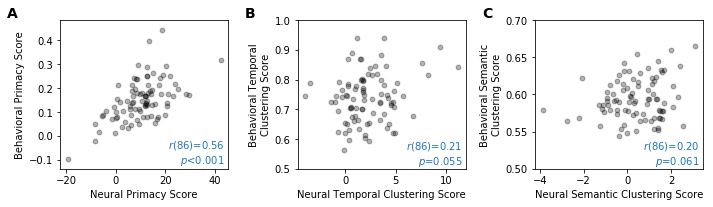

In [51]:
fig, axes = plt.subplots(1, 3, figsize=[10,3])

ax = axes[0]
ax.scatter(enc_stats['early_middle_t'], enc_stats['primacy_factors'], color='black', s=23, alpha=0.3)
ax.set_xlabel('Neural Primacy Score')
ax.set_ylabel('Behavioral Primacy Score')
ax.text(44, -0.072, r'$\it{r}$'+'(86)=0.56\n'+r'$\it{p}$<0.001', ha='right', va='center', color='C0')
ax.set_yticks(np.arange(-0.1, 0.41, 0.1))
ax.text(-0.25, 1.09, 'A', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

ax = axes[1]
ax.scatter(enc_stats['tc_nc_t'], enc_stats['temp_factors'], color='black', s=23, alpha=0.3)
ax.set_xlabel('Neural Temporal Clustering Score')
ax.set_ylabel('Behavioral Temporal\nClustering Score')
ax.text(11.6, 0.55, r'$\it{r}$'+'(86)=0.21\n'+r'$\it{p}$=0.055', ha='right', va='center', color='C0')
ax.set_yticks(np.arange(0.5, 1.01, 0.1))
ax.text(-0.25, 1.09, 'B', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

ax = axes[2]
axes[2].scatter(enc_stats['sc_nc_t'], enc_stats['sem_factors'], color='black', s=23, alpha=0.3)
ax.set_xlabel('Neural Semantic Clustering Score')
ax.set_ylabel('Behavioral Semantic\nClustering Score')
ax.text(3.3, 0.52, r'$\it{r}$'+'(86)=0.20\n'+r'$\it{p}$=0.061', ha='right', va='center', color='C0')
ax.set_yticks(np.arange(0.5, 0.71, 0.05))
ax.text(-0.25, 1.09, 'C', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

fig.tight_layout()

In [52]:
# fig.savefig('figures_final/corr.pdf')

#### retrieval correlation with behavioral indexes of memory

In [86]:
# match retrieval yhat with events
merged_yhat_events_rec_all = []
for i, subject in enumerate(ret_sig_subjects):
    
    def get_recall_status(select_events, all_events):
        
        subject_data = all_events[all_events['subject']==subject]
        subject_data = subject_data.sort_values('mstime')
        events_index = np.in1d(subject_data['mstime'].values, select_events['mstime'])
        x = pd.DataFrame(subject_data[['subject', 'session', 'trial', 'serialpos', 'intrusion', 'rectime']][events_index])
        
        intrusions = subject_data[events_index]['intrusion'].values
        
        TC = np.array(np.abs(subject_data[events_index]['lag2'])==1)
        SC = np.array(subject_data[events_index]['sim2']>=0.4)
        
        conditions = []
        for i in range(len(TC)):
            if intrusions[i] == 0:
                if (TC[i]) and (SC[i]): conditions.append('BC')
                elif TC[i]: conditions.append('TC')
                elif SC[i]: conditions.append('SC')
                else: conditions.append('NC')
            else:
                conditions.append('IN')
                
        x['condition'] = conditions
        return x
    
    yhat = retciresults[i]['yhat']
    events = retciresults[i]['events']
    merged_yhat_events = get_recall_status(events, ret_labeled_events)
    merged_yhat_events['yhat'] = yhat
    merged_yhat_events_rec_all.append(merged_yhat_events)
    
merged_yhat_events_rec_all = pd.concat(merged_yhat_events_rec_all)

In [156]:
ret_early_middle_t = []
rec_tc_nc_t = []
rec_sc_nc_t = []
for s in ret_sig_subjects:
    x = merged_yhat_events_rec_all[merged_yhat_events_rec_all['subject']==s]
    # tc vs. nc
    t, p = sp.stats.ttest_ind(x['yhat'][x['condition']=='TC'], 
                              x['yhat'][x['condition']=='NC'])
    rec_tc_nc_t.append(t)
    # sc vs. nc
    t, p = sp.stats.ttest_ind(x['yhat'][x['condition']=='SC'], 
                              x['yhat'][x['condition']=='NC'])
    rec_sc_nc_t.append(t)
    # early vs. middle
    early = np.array([np.nanmean(x['yhat'][(x['session']==sess)&(x['trial']==trial)&(x['rectime'].values<=22500)]) 
                      for sess, trial in x[['session','trial']].drop_duplicates().values]) # 0s ~ 22.5s
    middle = np.array([np.nanmean(x['yhat'][(x['session']==sess)&(x['trial']==trial)&(x['rectime'].values>22500)&(x['rectime'].values<=52500)]) 
                      for sess, trial in x[['session','trial']].drop_duplicates().values]) # 22.5s ~ 52.5s
    t, p = sp.stats.ttest_ind(early, middle, nan_policy='omit')
    ret_early_middle_t.append(t)

In [157]:
rec_stats = pd.DataFrame(data=ret_sig_subjects, columns=['subject'])
rec_stats['rec_tc_nc_t'] = rec_tc_nc_t
rec_stats['rec_sc_nc_t'] = rec_sc_nc_t
rec_stats['ret_early_middle_t'] = ret_early_middle_t

In [158]:
print(sp.stats.pearsonr(rec_stats['ret_early_middle_t'], enc_stats['primacy_factors'][np.in1d(enc_sig_subjects, ret_sig_subjects)]))
print(sp.stats.pearsonr(rec_stats['rec_tc_nc_t'], enc_stats['temp_factors'][np.in1d(enc_sig_subjects, ret_sig_subjects)]))
print(sp.stats.pearsonr(rec_stats['rec_sc_nc_t'], enc_stats['sem_factors'][np.in1d(enc_sig_subjects, ret_sig_subjects)]))

(-0.23049366413489963, 0.066897116560013)
(-0.017282284061482227, 0.8921822591492945)
(0.3961307005005808, 0.0011942806115216452)
